In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
import random

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
df = pd.read_csv('../CSV files/dataset_cleaned.csv')

print(df.shape)
print(df.info())
display(df.head())

(76712, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76712 entries, 0 to 76711
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  76712 non-null  object
 1   label     76712 non-null  object
 2   label_id  76712 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ MB
None


,filename,label,label_id
0,angry_fer0032225.png,angry,0
1,angry_fer0032228.png,angry,0
2,angry_fer0032239.png,angry,0
3,angry_fer0032242.png,angry,0
4,angry_fer0032258.png,angry,0


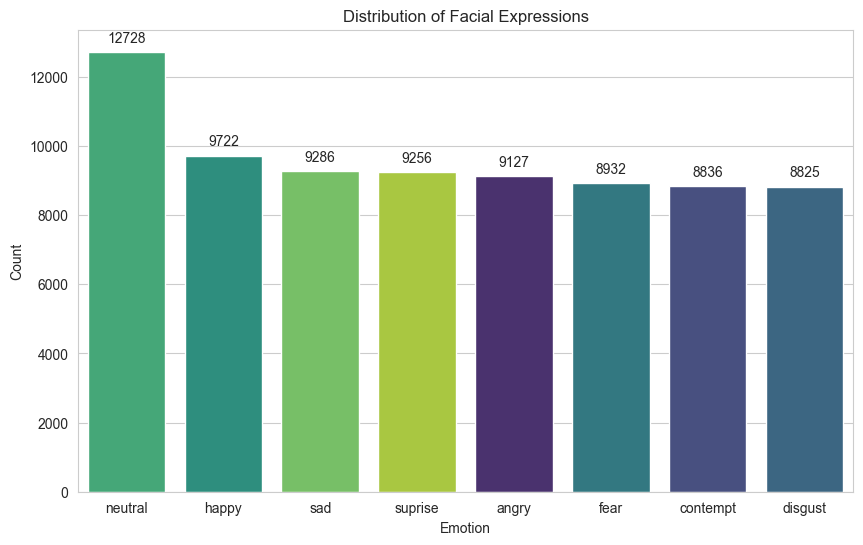

In [5]:
plt.figure(figsize=(10, 6))

ax = sns.countplot(data=df, x='label', hue='label', legend=False, order=df['label'].value_counts().index, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribution of Facial Expressions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

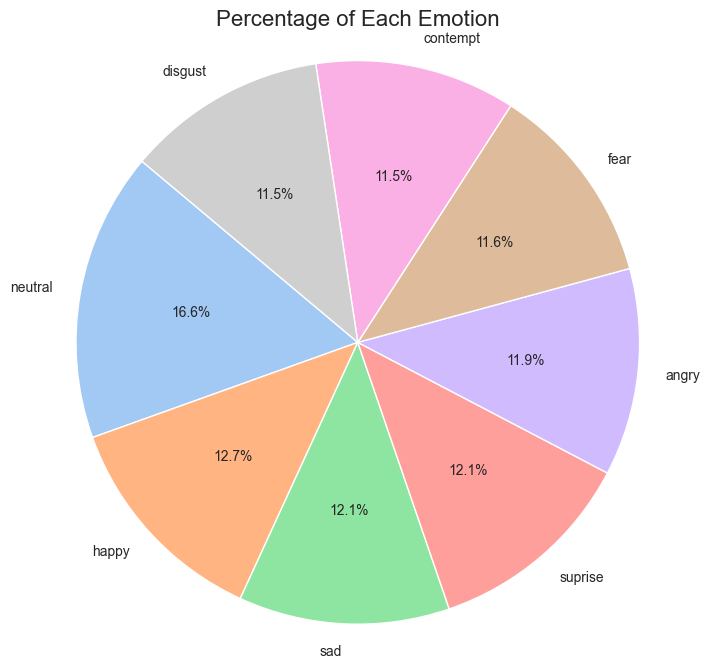

In [4]:
plt.figure(figsize=(8, 8))
label_counts = df['label'].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Percentage of Each Emotion', fontsize=16)
plt.axis('equal') 
plt.show()

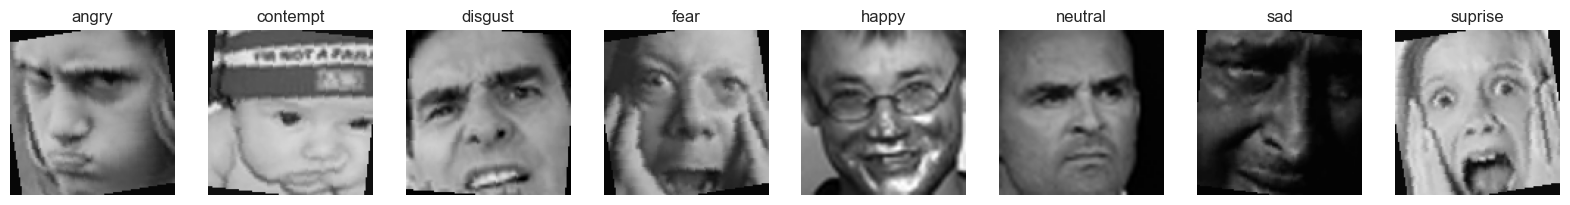

In [6]:
IMAGE_DIR = "../data"
unique_labels = df['label'].unique()

fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 5))

for i, label in enumerate(unique_labels):
    sample_row = df[df['label'] == label].sample(1).iloc[0]
    image_name = sample_row['filename']
    image_path = os.path.join(IMAGE_DIR, image_name)

    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')
    except Exception:
        axes[i].text(0.5, 0.5, "Not Found", ha='center')
        axes[i].axis('off')

plt.show()

Processing images for t-SNE...


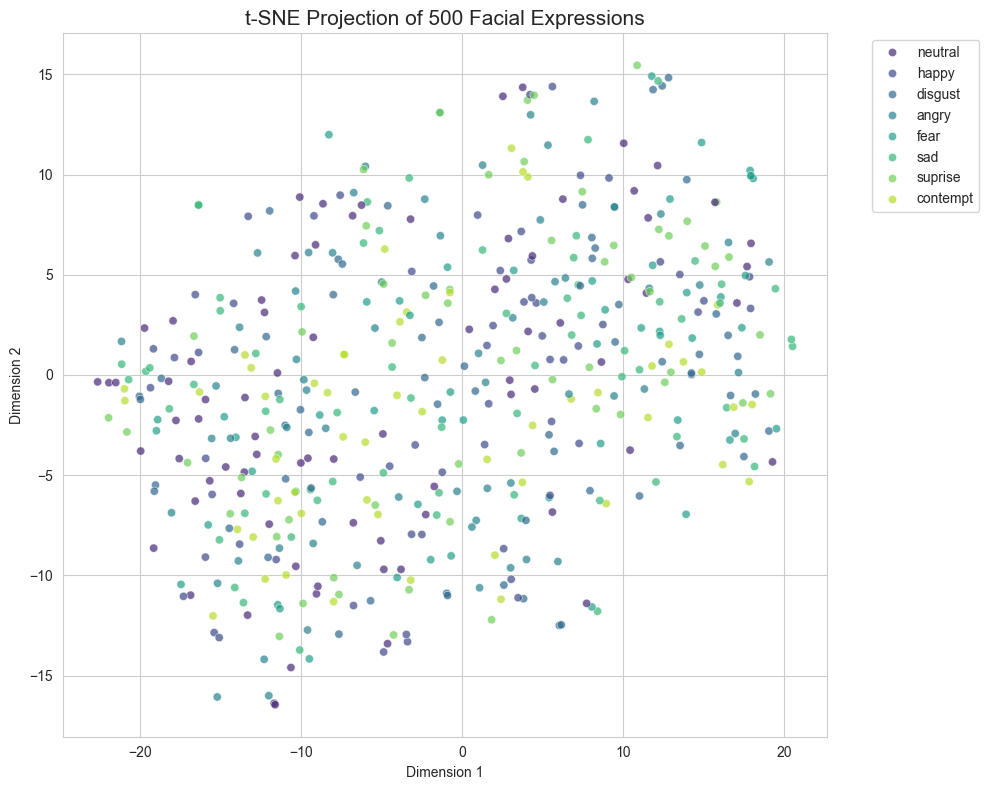

In [16]:
# ایده ۱: مصورسازی پراکندگی داده‌ها با t-SNE (اصلاح شده)
from sklearn.manifold import TSNE
import numpy as np       # <--- این خط ضروری است
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

# تنظیمات
n_samples = 500
# اگر تعداد کل داده‌ها کمتر از 500 بود، همه‌ی آن‌ها را بردار
n_samples = min(n_samples, len(df))

subset_df = df.sample(n_samples, random_state=42)
image_data = []
labels = []

print("Processing images for t-SNE...")

for index, row in subset_df.iterrows():
    # نکته: مطمئن شوید IMAGE_DIR درست تنظیم شده باشد (مثلاً "../data")
    path = os.path.join(IMAGE_DIR, row['filename'])
    try:
        img = cv2.imread(path, 0) # سیاه و سفید
        if img is not None:
            img = cv2.resize(img, (48, 48))
            image_data.append(img.flatten())
            labels.append(row['label'])
    except:
        pass

# --- بخش اصلاح شده ---
# تبدیل لیست به آرایه نامپای
X = np.array(image_data)

# بررسی اینکه آیا عکسی لود شده یا خیر
if len(X) > 0:
    # Perplexity باید کمتر از تعداد نمونه‌ها باشد
    perp = min(30, len(X) - 1)
    
    if perp < 5:
        print("Not enough data points for t-SNE!")
    else:
        tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
        X_tsne = tsne.fit_transform(X)

        # رسم نمودار
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='viridis', alpha=0.7)
        plt.title(f't-SNE Projection of {len(X)} Facial Expressions', fontsize=15)
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        # انتقال Legend به بیرون نمودار برای دیده شدن بهتر
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
else:
    print("Error: No images loaded. Please check 'IMAGE_DIR' path.")

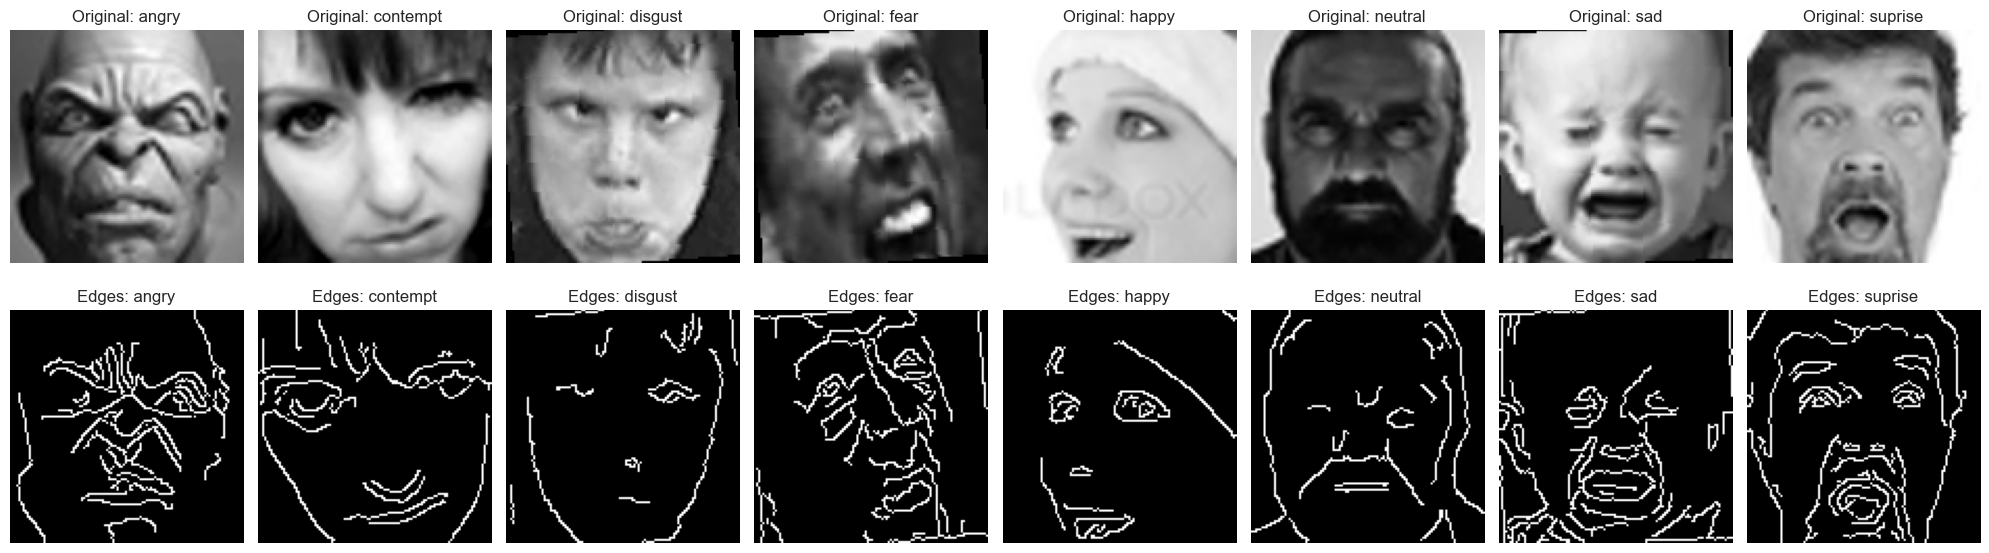

In [12]:
# ایده ۲: نمایش لبه‌های تصویر (Canny Edge Detection)
unique_labels = df['label'].unique()

fig, axes = plt.subplots(2, len(unique_labels), figsize=(20, 6))

for i, label in enumerate(unique_labels):
    # گرفتن یک نمونه
    sample_row = df[df['label'] == label].sample(1).iloc[0]
    path = os.path.join(IMAGE_DIR, sample_row['filename'])
    
    img = cv2.imread(path, 0) # Grayscale
    
    if img is not None:
        # 1. تصویر اصلی
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"Original: {label}")
        axes[0, i].axis('off')
        
        # 2. تصویر لبه‌یابی شده
        edges = cv2.Canny(img, 100, 200)
        axes[1, i].imshow(edges, cmap='gray')
        axes[1, i].set_title(f"Edges: {label}")
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

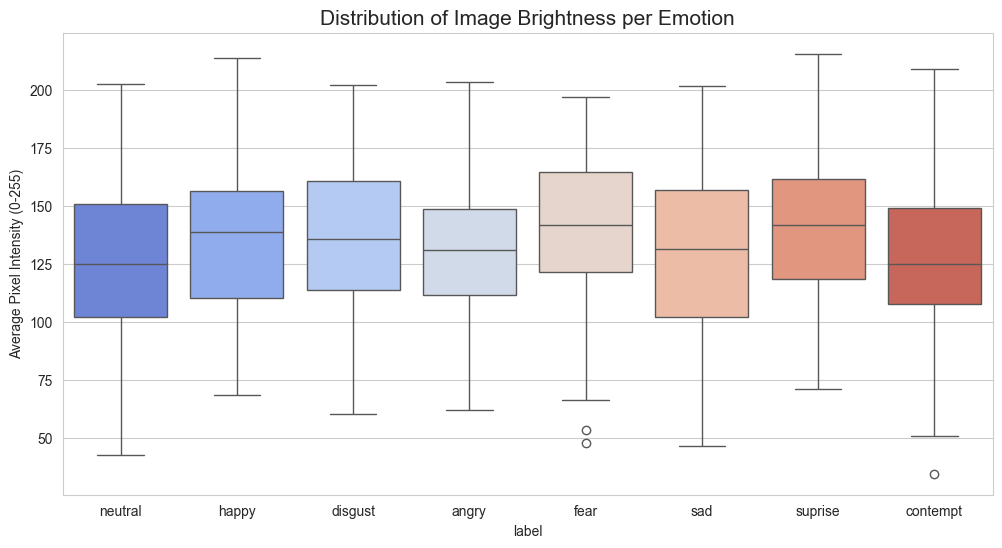

In [14]:
# ایده ۳: نمودار جعبه‌ای روشنایی تصاویر (Brightness Stats)
brightness_data = []

# انتخاب 1000 نمونه تصادفی
subset_df = df.sample(1000, random_state=42)

for index, row in subset_df.iterrows():
    path = os.path.join(IMAGE_DIR, row['filename'])
    try:
        img = cv2.imread(path, 0)
        if img is not None:
            avg_brightness = img.mean() # میانگین پیکسل‌های عکس
            brightness_data.append({'label': row['label'], 'brightness': avg_brightness})
    except:
        pass

brightness_df = pd.DataFrame(brightness_data)

plt.figure(figsize=(12, 6))
sns.boxplot(data=brightness_df, x='label', y='brightness',hue='label', legend=False, palette='coolwarm')
plt.title('Distribution of Image Brightness per Emotion', fontsize=15)
plt.ylabel('Average Pixel Intensity (0-255)')
plt.show()